<a href="https://colab.research.google.com/github/harald-gen01/My_AI_learning_path/blob/main/Measure_%26_Refine_with_Hugging_Face_(SQuAD_v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install dependencies**

In [42]:
!pip -q install -U datasets langchain langgraph langchain-openai langchain-community chromadb langchain-text-splitters pandas

**Imports**

In [43]:
import os
import random
import time
import pandas as pd

from typing import List, Literal, TypedDict, Optional
from pydantic import BaseModel, Field

from datasets import load_dataset

from langgraph.graph import StateGraph, END

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [44]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('openai_api_key')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

HF_TOKEN = userdata.get('HF_TOKEN')
os.environ["HF_TOKEN"] = HF_TOKEN

**Models**

In [45]:
SMALL_MODEL = "gpt-5-nano"
MAIN_MODEL  = "gpt-5.2"

llm_small = ChatOpenAI(model=SMALL_MODEL, temperature=0)
llm_main  = ChatOpenAI(model=MAIN_MODEL, temperature=0)

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")




**Step A: Load SQuAD v2 (Hugging Face)**

Load + sample dataset (minimal)


SQuAD v2 gives us:

- context (our “internal KB docs”)

- question (the user query)

- is_impossible (expected refusal when True)

In [46]:

from datasets import load_dataset

dataset = load_dataset("rajpurkar/squad_v2", split="validation")

SAMPLE_SIZE = 200
seed = 42
random.seed(seed)

sample_indices = random.sample(range(len(dataset)), SAMPLE_SIZE)
sample = dataset.select(sample_indices)

sample[0]


{'id': '5ad031ef77cf76001a686df5',
 'title': 'Imperialism',
 'context': 'France took control of Algeria in 1830 but began in earnest to rebuild its worldwide empire after 1850, concentrating chiefly in North and West Africa, as well as South-East Asia, with other conquests in Central and East Africa, as well as the South Pacific. Republicans, at first hostile to empire, only became supportive when Germany started to build her own colonial empire. As it developed, the new empire took on roles of trade with France, supplying raw materials and purchasing manufactured items, as well as lending prestige to the motherland and spreading French civilization and language as well as Catholicism. It also provided crucial manpower in both World Wars.',
 'question': ' When did French Republicans back building the English empire?',
 'answers': {'text': [], 'answer_start': []}}

**Step B: Build the “internal knowledge base” from dataset contexts**

Chunk contexts (important for retrieval quality)

In [47]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=80
)

contexts = list(set(sample["context"]))  # unique contexts
chunks = []
for c in contexts:
    chunks.extend(text_splitter.split_text(c))

# Cap for cost + speed
MAX_CHUNKS = 2000
chunks = chunks[:MAX_CHUNKS]

print("Unique contexts:", len(contexts))
print("Total chunks indexed:", len(chunks))
print("Example chunk:\n", chunks[0][:300])


Unique contexts: 178
Total chunks indexed: 343
Example chunk:
 For instance, while traveling in a moving vehicle at a constant velocity, the laws of physics do not change from being at rest. A person can throw a ball straight up in the air and catch it as it falls down without worrying about applying a force in the direction the vehicle is moving. This is true 


In [48]:
print("embeddings =", embeddings)
print("type(embeddings) =", type(embeddings))


embeddings = text-embedding-3-small
type(embeddings) = <class 'str'>


**Build Chroma vector DB**

In [66]:
vectorstore = Chroma.from_texts(
    texts=chunks,
    embedding=embedding_model,
    collection_name="squad_v2_kb"
)

internal_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

print("internal_retriever ready:", type(internal_retriever))


internal_retriever ready: <class 'langchain_core.vectorstores.base.VectorStoreRetriever'>


In [67]:
print(sample.column_names)


['id', 'title', 'context', 'question', 'answers']


**Step C: Modular RAG Graph (internal-only, aligned with the blog)**

We keep the full “Judgment + Self-correction + Refusal” pipeline.

**Graph State**

In [68]:
class GraphState(TypedDict):
    query: str

    internal_docs: List[str]
    evidence_pool: List[str]

    top_evidence: Optional[str]
    confidence: float

    draft_answer: Optional[str]
    critic_verdict: Optional[str]
    critic_reason: Optional[str]

    retry_count: int
    final_answer: Optional[str]


**Structured outputs (Judge + Critic)**

In [69]:
class EvidenceJudgment(BaseModel):
    best_index: int = Field(..., description="Index of best evidence passage in evidence pool")
    confidence: float = Field(..., ge=0.0, le=1.0)
    rationale: str = Field(...)

class CriticResult(BaseModel):
    verdict: Literal["PASS", "FAIL"] = Field(...)
    reason: str = Field(...)
    suggested_query: Optional[str] = Field(None)


**Nodes**

**Retrieve internal**

Note: modern retriever call uses .invoke().

In [70]:
def retrieve_internal(state: GraphState) -> GraphState:
    query = state["query"]
    docs = internal_retriever.invoke(query)
    texts = [d.page_content for d in docs]

    return {
        **state,
        "internal_docs": texts
    }


**Merge evidence (cap to avoid token blow-ups)**

In [71]:
def merge_evidence(state: GraphState) -> GraphState:
    merged = []
    seen = set()

    for t in state.get("internal_docs", []):
        tt = t.strip()
        if tt and tt not in seen:
            merged.append(tt)
            seen.add(tt)

    merged = merged[:8]  # cap
    return {
        **state,
        "evidence_pool": merged
    }


**Judge / Re-ranker (answerability)**

In [72]:
def judge_rerank(state: GraphState) -> GraphState:
    query = state["query"]
    pool = state["evidence_pool"]

    if not pool:
        return {**state, "top_evidence": None, "confidence": 0.0}

    pool_text = "\n\n".join([f"[{i}] {p}" for i, p in enumerate(pool)])

    prompt = f"""
You are an evidence judge for a Modular RAG system.

Pick the single passage that best ANSWERS the question.
Score answerability confidence from 0.0 to 1.0.
This is NOT similarity. It is whether the evidence contains the answer.

Question: {query}

Evidence pool:
{pool_text}
"""

    judgment = llm_small.with_structured_output(EvidenceJudgment).invoke(prompt)

    best_index = max(0, min(judgment.best_index, len(pool) - 1))
    top = pool[best_index]

    return {
        **state,
        "top_evidence": top,
        "confidence": float(judgment.confidence),
    }


**Generate grounded answer**

In [73]:
def generate_answer(state: GraphState) -> GraphState:
    query = state["query"]
    evidence = state.get("top_evidence") or ""

    prompt = f"""
You are a helpful assistant.

Rules:
- Answer using ONLY the evidence below.
- If the evidence does not contain the answer, say exactly:
  "I don't know based on the provided evidence."

Question: {query}

Evidence:
{evidence}

Answer:
"""
    answer = llm_main.invoke(prompt).content.strip()

    return {
        **state,
        "draft_answer": answer
    }


**Critic gate (PASS/FAIL)**

In [74]:
def critic_check(state: GraphState) -> GraphState:
    query = state["query"]
    evidence = state.get("top_evidence") or ""
    draft = state.get("draft_answer") or ""

    prompt = f"""
You are a strict critic for a Modular RAG assistant.

PASS only if:
- the answer is directly supported by the evidence
- it is specific (not generic filler)

FAIL if:
- it guesses beyond evidence
- it is unsupported or vague

Question: {query}

Evidence:
{evidence}

Draft Answer:
{draft}
"""

    result = llm_small.with_structured_output(CriticResult).invoke(prompt)

    return {
        **state,
        "critic_verdict": result.verdict,
        "critic_reason": result.reason
    }


**Rewrite query (retry once)**

In [75]:
def rewrite_query(state: GraphState) -> GraphState:
    query = state["query"]
    reason = state.get("critic_reason") or ""

    prompt = f"""
Rewrite the query to improve retrieval.
Keep the same intent.
Make it more specific and searchable.
Return only the rewritten query.

Original: {query}
Critic feedback: {reason}
"""

    rewritten = llm_small.invoke(prompt).content.strip()

    return {
        **state,
        "query": rewritten,
        "retry_count": state["retry_count"] + 1
    }


**Finalize (threshold + refusal)**

In [76]:
CONFIDENCE_THRESHOLD = 0.60

def finalize(state: GraphState) -> GraphState:
    conf = state.get("confidence", 0.0)
    verdict = state.get("critic_verdict", "FAIL")
    draft = state.get("draft_answer") or ""

    if conf >= CONFIDENCE_THRESHOLD and verdict == "PASS":
        final = draft
    else:
        final = "I don't know based on the provided evidence."

    return {**state, "final_answer": final}


**LangGraph wiring**

In [77]:
def should_retry(state: GraphState) -> str:
    if state.get("critic_verdict") == "FAIL" and state.get("retry_count", 0) < 1:
        return "retry"
    return "final"

builder = StateGraph(GraphState)

builder.add_node("retrieve_internal", retrieve_internal)
builder.add_node("merge_evidence", merge_evidence)
builder.add_node("judge_rerank", judge_rerank)
builder.add_node("generate_answer", generate_answer)
builder.add_node("critic_check", critic_check)
builder.add_node("rewrite_query", rewrite_query)
builder.add_node("finalize", finalize)

builder.set_entry_point("retrieve_internal")

builder.add_edge("retrieve_internal", "merge_evidence")
builder.add_edge("merge_evidence", "judge_rerank")
builder.add_edge("judge_rerank", "generate_answer")
builder.add_edge("generate_answer", "critic_check")

builder.add_conditional_edges(
    "critic_check",
    should_retry,
    {"retry": "rewrite_query", "final": "finalize"}
)

builder.add_edge("rewrite_query", "retrieve_internal")
builder.add_edge("finalize", END)

graph = builder.compile()


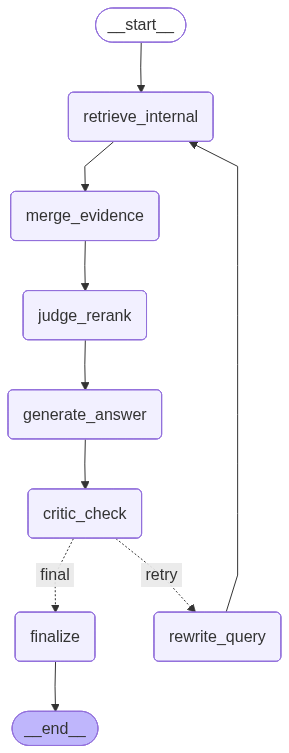

In [78]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

**Single-run helper (for educational visibility)**

In [79]:
def run_once(query: str) -> dict:
    state: GraphState = {
        "query": query,
        "internal_docs": [],
        "evidence_pool": [],
        "top_evidence": None,
        "confidence": 0.0,
        "draft_answer": None,
        "critic_verdict": None,
        "critic_reason": None,
        "retry_count": 0,
        "final_answer": None,
    }
    return graph.invoke(state)


**Step D: Evaluation Harness (Measure & Refine)**

**Refusal detection + scoring metrics**

In [80]:
def is_refusal(text: str) -> bool:
    return (text or "").strip() == "I don't know based on the provided evidence."


**RAG Triad scorer (LLM-as-judge, minimal)**

In [81]:
class TriadScores(BaseModel):
    context_relevance: float = Field(..., ge=0.0, le=1.0)
    groundedness: float = Field(..., ge=0.0, le=1.0)
    answer_relevance: float = Field(..., ge=0.0, le=1.0)
    rationale: str = Field(...)

def score_triad(query: str, evidence: str, answer: str) -> TriadScores:
    prompt = f"""
Score this RAG interaction from 0.0 to 1.0 on:

1) Context Relevance: evidence contains information to answer the question
2) Groundedness: answer is supported by evidence, no unsupported claims
3) Answer Relevance: answer addresses the question clearly

Return JSON scores and a short rationale.

Question: {query}

Evidence:
{evidence}

Answer:
{answer}
"""
    return llm_small.with_structured_output(TriadScores).invoke(prompt)


**Run evaluation on SQuAD v2 sample**

In [83]:
EVAL_RUN_SIZE = 10  # keep it small to avoid costs, you can go up this number, the time will increase
eval_subset = sample.select(range(EVAL_RUN_SIZE))

rows = []
start_time = time.time()

for ex in eval_subset:
    q = ex["question"]
    answers = ex["answers"]
    expected_refuse = (len(answers["text"]) == 0)

    out = run_once(q)

    evidence = out.get("top_evidence") or ""
    answer = out.get("final_answer") or ""

    refused = is_refusal(answer)
    refusal_correct = (expected_refuse and refused) or ((not expected_refuse) and (not refused))

    triad = score_triad(q, evidence, answer)

    rows.append({
        "question": q,
        "expected_refuse": expected_refuse,
        "refused": refused,
        "refusal_correct": refusal_correct,
        "confidence": round(float(out.get("confidence", 0.0)), 2),
        "critic": out.get("critic_verdict"),
        "retry_count": out.get("retry_count"),
        "context_relevance": round(triad.context_relevance, 2),
        "groundedness": round(triad.groundedness, 2),
        "answer_relevance": round(triad.answer_relevance, 2),
    })

df = pd.DataFrame(rows)
elapsed = time.time() - start_time

df.head(10), elapsed

(                                            question  expected_refuse  \
 0   When did French Republicans back building the...             True   
 1  Who was the final Prime Minister of East Germany?            False   
 2  What has complicated definitions that prevent ...            False   
 3                                Telnet was sold to             False   
 4  The BankAmericard could be used across many me...             True   
 5  What does ctenophora rely on for digestion and...            False   
 6             What element has a symbol number of 8?             True   
 7  When were these settlers naturalized as Englis...            False   
 8               What profession was Nathan Alterman?            False   
 9     What is the logic behind the cicadas outbreak?             True   
 
    refused  refusal_correct  confidence critic  retry_count  \
 0    False            False        0.83   PASS            1   
 1    False             True        0.92   PASS         

In [84]:
print("=== Scoreboard (Measure & Refine) ===")
print("Eval samples:", len(df))
print("Refusal correctness:", round(df["refusal_correct"].mean(), 2))
print("Avg Context Relevance:", round(df["context_relevance"].mean(), 2))
print("Avg Groundedness:", round(df["groundedness"].mean(), 2))
print("Avg Answer Relevance:", round(df["answer_relevance"].mean(), 2))
print("Avg retries:", round(df["retry_count"].mean(), 2))


=== Scoreboard (Measure & Refine) ===
Eval samples: 10
Refusal correctness: 0.5
Avg Context Relevance: 0.71
Avg Groundedness: 0.89
Avg Answer Relevance: 0.8
Avg retries: 0.3


**Step E: The fun part (Refine knob -> measure improvement)**


Two easy knobs:

- Knob A: increase Top-K retrieval

  internal_retriever = vectorstore.as_retriever(search_kwargs={"k": 8})

- Knob B: tighten threshold for safety

  CONFIDENCE_THRESHOLD = 0.70

Then re-run ["Run evaluation on SQuAD v2 sample"](https://colab.research.google.com/drive/1QUgkTzA-4l3hXNEeclGR_IljkhOBzzG4#scrollTo=KKF52WMmrVRV&line=2&uniqifier=1)